<a href="https://colab.research.google.com/github/benkivuva/100-DaysOfCode/blob/main/Project_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

#Data Preparation: Selecting Relevant Columns
This cell prepares the dataset for analysis by reading a CSV file named "SeoulBikeData.csv" located at "/content/sample_data/". It selects specific columns of interest defined in the dataset_cols list and drops the "Date", "Holiday", and "Seasons" columns from the DataFrame. The resulting DataFrame, stored in the variable df, is ready for further analysis.

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("/content/sample_data/SeoulBikeData.csv", encoding= 'unicode_escape').drop(["Date", "Holiday", "Seasons"], axis=1)

**Data Preparation for Analysis**

In this section of the notebook, we are preparing the DataFrame `df` for further analysis. The first line sets the column names of the DataFrame to match the list `dataset_cols`, ensuring that only the relevant columns are retained. Next, we convert the "functional" column to numeric values, where "Yes" becomes 1 and "No" becomes 0. We then filter the DataFrame to keep only the rows where the "hour" column has a value of 12. After that, we drop the "hour", "wind", "visibility", and "functional" columns to focus on the specific attributes of interest for our analysis. The resulting DataFrame will now contain the selected columns and rows ready for exploration and modeling.

In [ ]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [ ]:
df = df.drop(["wind", "visibility", "functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


**Visualization: Scatter Plots of Features**

Next we generate scatter plots to visualize the relationship between each feature in the DataFrame df (excluding the first column) and the "bike_count" variable. For each feature, a scatter plot is created using plt.scatter(), where the feature values are plotted on the x-axis and the corresponding "bike_count" values are plotted on the y-axis.

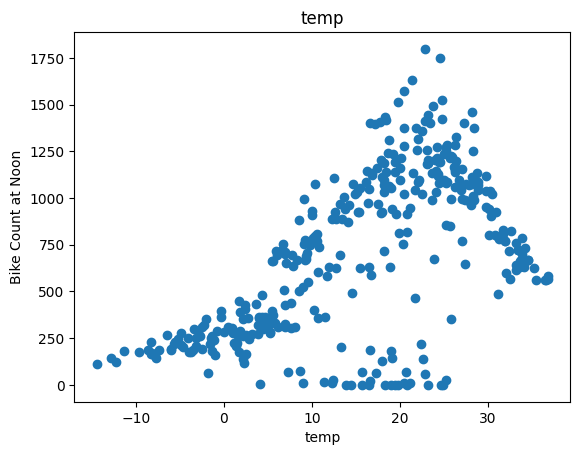

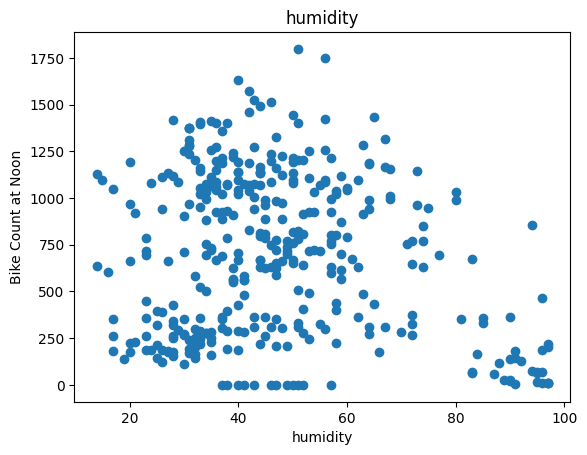

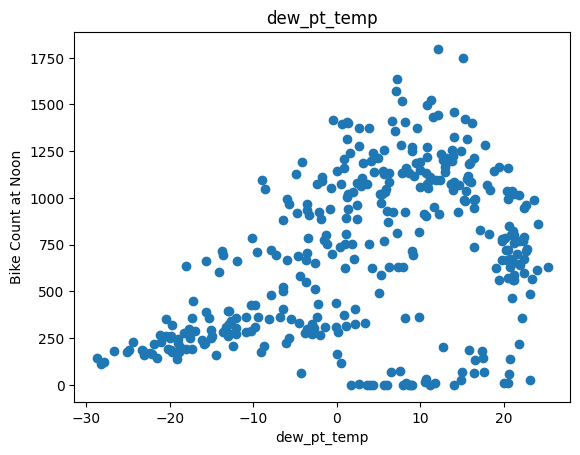

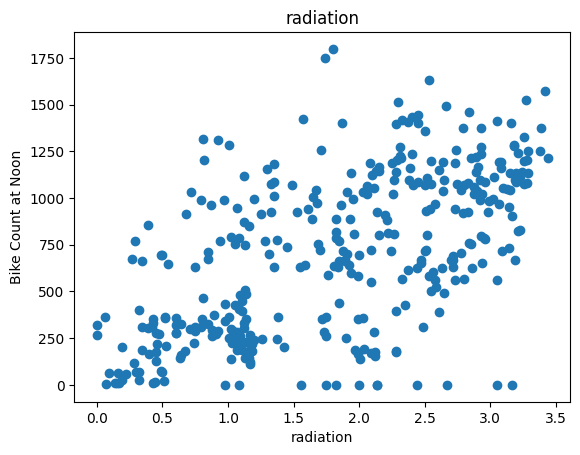

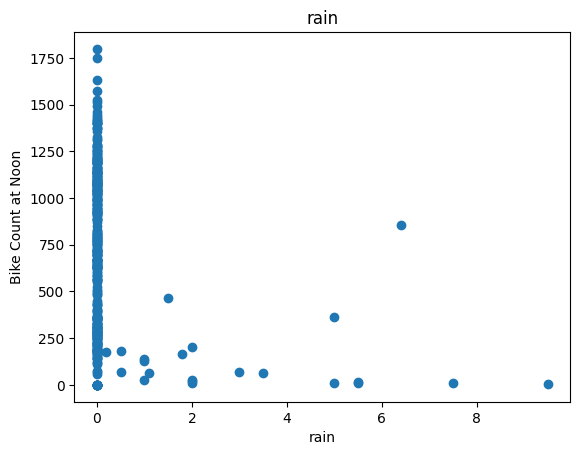

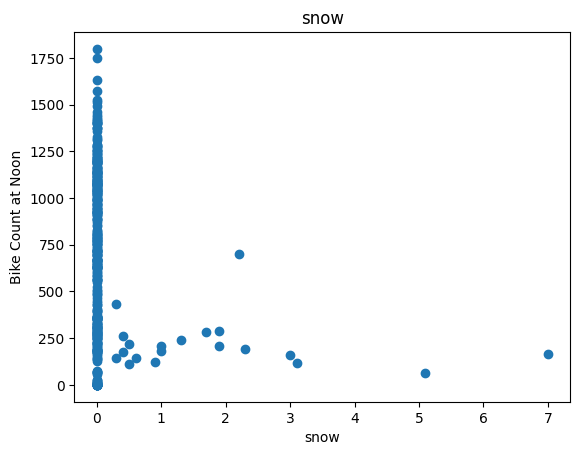

In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

# Train/valid/test dataset
We then split the DataFrame `df` into three subsets: `train`, `val`, and `test`, using a random shuffling technique. The data is divided based on the proportions of approximately 60% for training, 20% for validation, and 20% for testing. Furthermore, a function called `get_xy()` is defined to extract input features and target variables from a DataFrame. This function enables flexibility in selecting the desired columns as input features and the specified column as the target variable.

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

**Data Preprocessing: Extracting Temp as Input Feature**

In this step, we use the `get_xy()` function to extract the "temp" column as the input feature and "bike_count" as the target variable from the three subsets: `train`, `val`, and `test`. For each subset, we call the `get_xy()` function with the specified DataFrame and column labels. The result provides the input features and target variables for each subset separately: `X_train_temp`, `y_train_temp` for training, `X_val_temp`, `y_val_temp` for validation, and `X_test_temp`, `y_test_temp` for testing. By isolating the "temp" column, we can focus on its influence on the target variable "bike_count" in our subsequent analysis and modeling.

In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

**Linear Regression: Predicting Bike Count based on Temperature**

We utilize linear regression to predict bike count based on the temperature feature. First, we create a `LinearRegression` model instance named `temp_reg`. Next, we train the model using the training data (`X_train_temp`, `y_train_temp`) with `temp_reg.fit()`. Finally, we evaluate the model's performance on the test data (`X_test_temp`, `y_test_temp`) using the coefficient of determination (R^2) with `temp_reg.score()`. This R^2 value assesses how well the model's predictions align with the actual bike counts. An R^2 value of 0.34 suggests that approximately 34% of the variance in the bike count can be explained by the temperature feature. This value indicates a moderate correlation between temperature and bike count, indicating that temperature alone may not be the sole determining factor for bike count fluctuations.

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [ ]:
temp_reg.score(X_test_temp, y_test_temp)

0.34053787785485135

This code creates a scatter plot (`blue`) of the training data (`X_train_temp` and `y_train_temp`). It then plots the linear regression model's predictions (`red`) for temperatures ranging from -20 to 40. The plot is labeled and titled, representing the relationship between bike count and temperature.

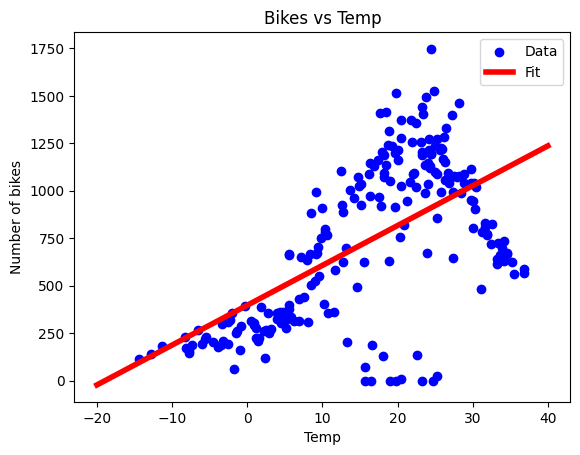

In [38]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=4)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [39]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [40]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [46]:
all_reg.score(X_test_all, y_test_all)

0.38738182612248906

In [47]:
y_pred_lr = all_reg.predict(X_test_all)

# Regression with Neural Net

In [48]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [49]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [ ]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

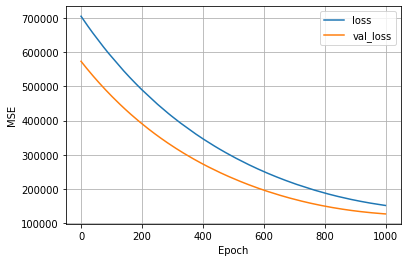

In [ ]:
plot_loss(history)

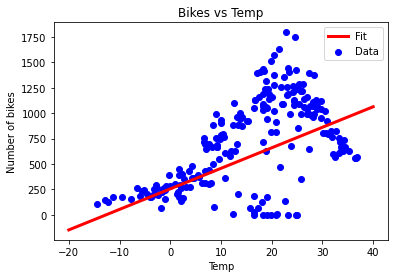

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Net

In [55]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [56]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

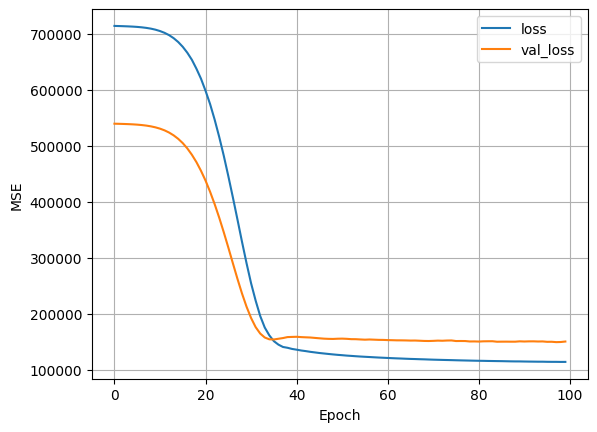

In [53]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


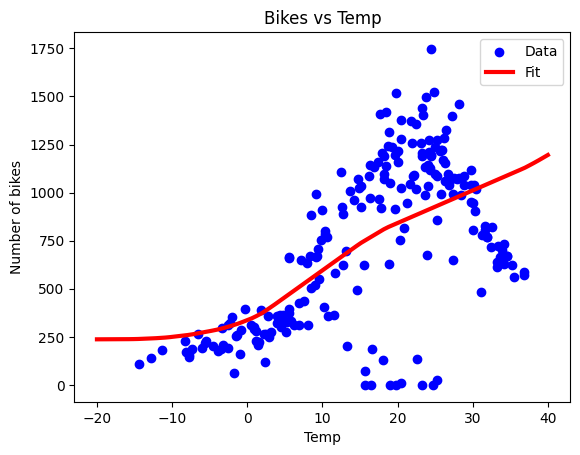

In [57]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [59]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [60]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [61]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

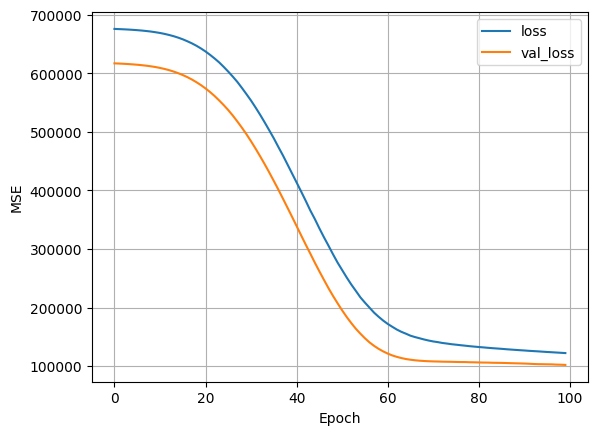

In [62]:
plot_loss(history)

In [63]:
# calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 3ms/step


In [64]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [65]:
MSE(y_pred_lr, y_test_all)

94234.75765808646

In [66]:
MSE(y_pred_nn, y_test_all)

128058.42379226668

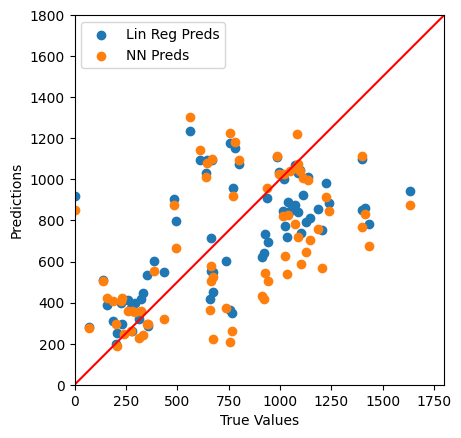

In [67]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")